# __Boosting__

## 1. Import necessary libraries

In [59]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

# Machine learning libraries
import math
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text

# mltools (custom library)
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

## 2. Load data as a Pandas DataFrame

In [60]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [61]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [62]:
# Unimos ambos dataframes
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')

# Separamos el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformamos los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')

# Ajustamos la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)
df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraemos las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unimos los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [63]:
# Convertimos 'FranjaHoraria' a integer y ordenamos el df
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

# Calculamos los lags de irradiación
df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes

# Calculamos los lags de utilización
df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

# Eliminamos los valores nulos
df_final = df_final.dropna()

# Cambiamos ANNO, MES, DIA, DIASEM y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

In [64]:
# Inputs of the model
INPUTS_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] # Weekday is numerical in this case - Intervention variables
INPUTS = INPUTS_NUM + INPUTS_CAT
OUTPUT = 'Utilizacion'

#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS]
y = df_final[OUTPUT]

# Divide the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,  #percentage of test data
                                                   random_state=999) #seed for replication

# Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test

# Print the sizes of the training and test datasets
print("Size of the training set:", dfTR_eval.shape)
print("Size of the test set:", dfTS_eval.shape)

Size of the training set: (11692, 15)
Size of the test set: (2924, 15)


## 3. Fit the models

#### a) Single Regression Tree

In [7]:
# Inputs of the model
INPUTS_DT = INPUTS

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
single_reg_tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
                       
single_reg_tree_fit.fit(X_train, y_train) # Search in grid


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [8]:
# Show the best grid parameter combination found by CV
single_reg_tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

In [9]:
# Predict
y_train_est = single_reg_tree_fit.best_estimator_['DT'].predict(X_train)
y_test_est = single_reg_tree_fit.best_estimator_['DT'].predict(X_test)
num_nodes = single_reg_tree_fit.best_estimator_['DT'].tree_.node_count
# Obtain a report of the model based on predictions
dfTR_eval['DT_pred'] = y_train_est
dfTS_eval['DT_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred']))

Training MAE: 0.010256035194095913
Test MAE: 0.016525688289265983
Training RMSE: 0.019837568229661554
Test RMSE: 0.031931721318362194
Training R2: 0.9706460139734515
Test R2: 0.9216024435164134


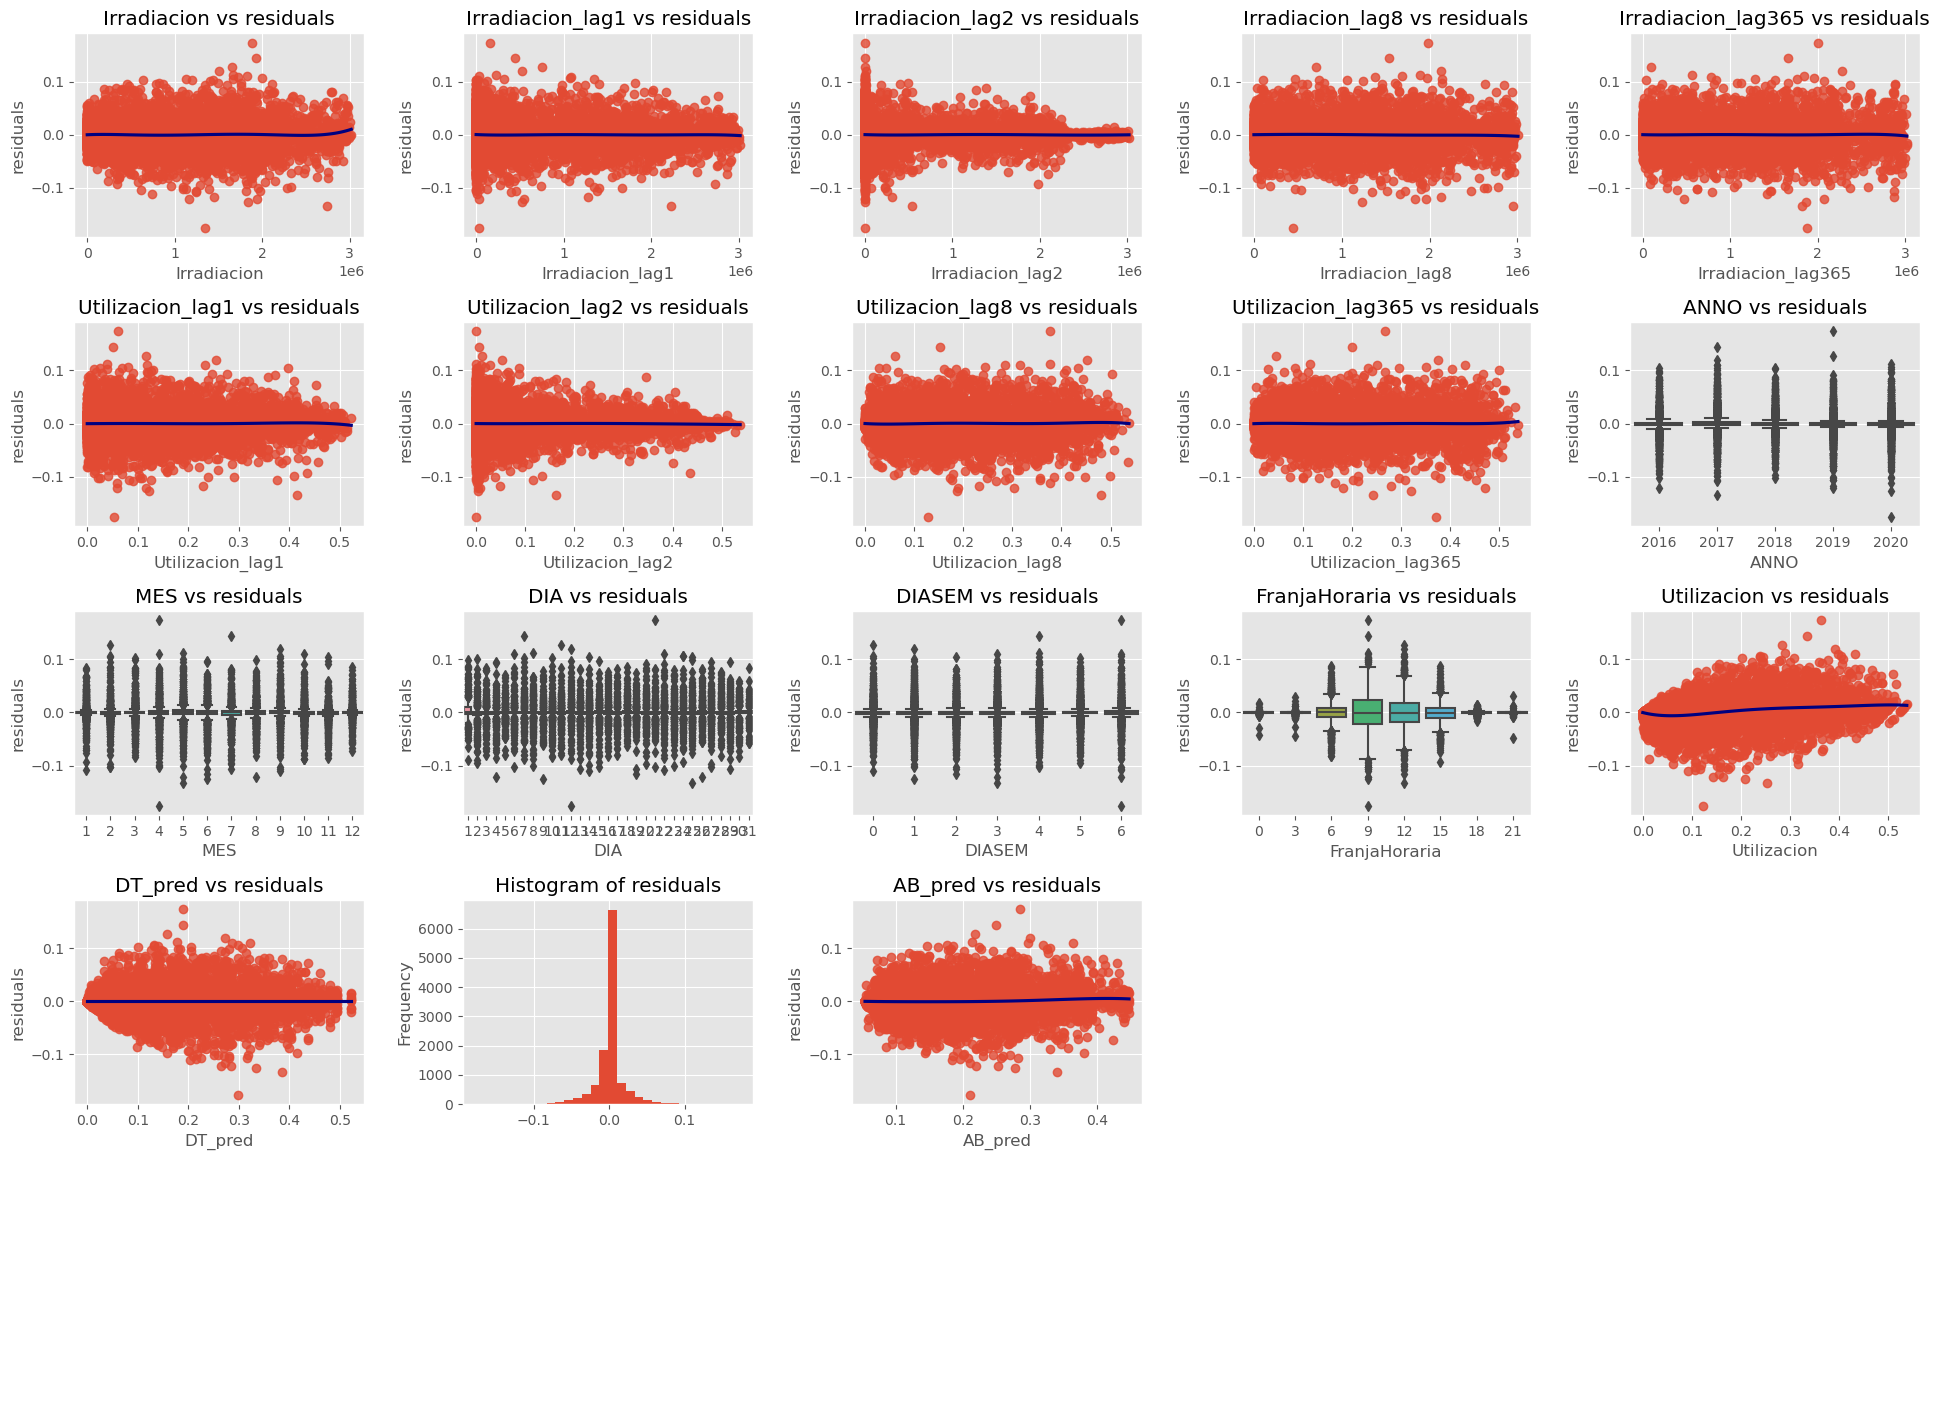

In [19]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'DT_pred', 'Utilizacion', figsize=[20,15])

#### b) AdaBoost

In [30]:
# Define the parameter grid
param_grid = {
    'ADA__base_estimator__max_depth': list(range(2, 11, 2)),  # Profundidades del árbol de decisión
    'ADA__base_estimator__min_impurity_decrease': np.arange(0.0, 0.21, 0.05),  # Umbral para reducción de impureza
    'ADA__n_estimators': list(range(50, 201, 50))  # Número de árboles en el AdaBoost
}

# Prepare the data
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_NUM),
    ('cat', categorical_transformer, INPUTS_CAT)
])

# Define the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ADA', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=999))
])

# Create the GridSearchCV object
nFolds = 10
AdaBoost_fit = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid, 
                            cv=nFolds, 
                            verbose=1, 
                            n_jobs=-1)

# Fit the GridSearchCV object to the training data
AdaBoost_fit.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", AdaBoost_fit.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWar

In [ ]:
AdaBoost_fit.best_estimator_['base_estimator'].get_params()

In [22]:
# Predict
y_train_est = AdaBoost_fit.predict(X_train)
y_test_est = AdaBoost_fit.predict(X_test)
# Obtain a report of the model based on predictions
dfTR_eval['AB_pred'] = y_train_est
dfTS_eval['AB_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['AB_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['AB_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['AB_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['AB_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['AB_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['AB_pred']))

Training MAE: 0.052335911820688856
Test MAE: 0.05264782377027811
Training RMSE: 0.056293399306555233
Test RMSE: 0.05710643797843845
Training R2: 0.7636230278491242
Test R2: 0.7492574664937272


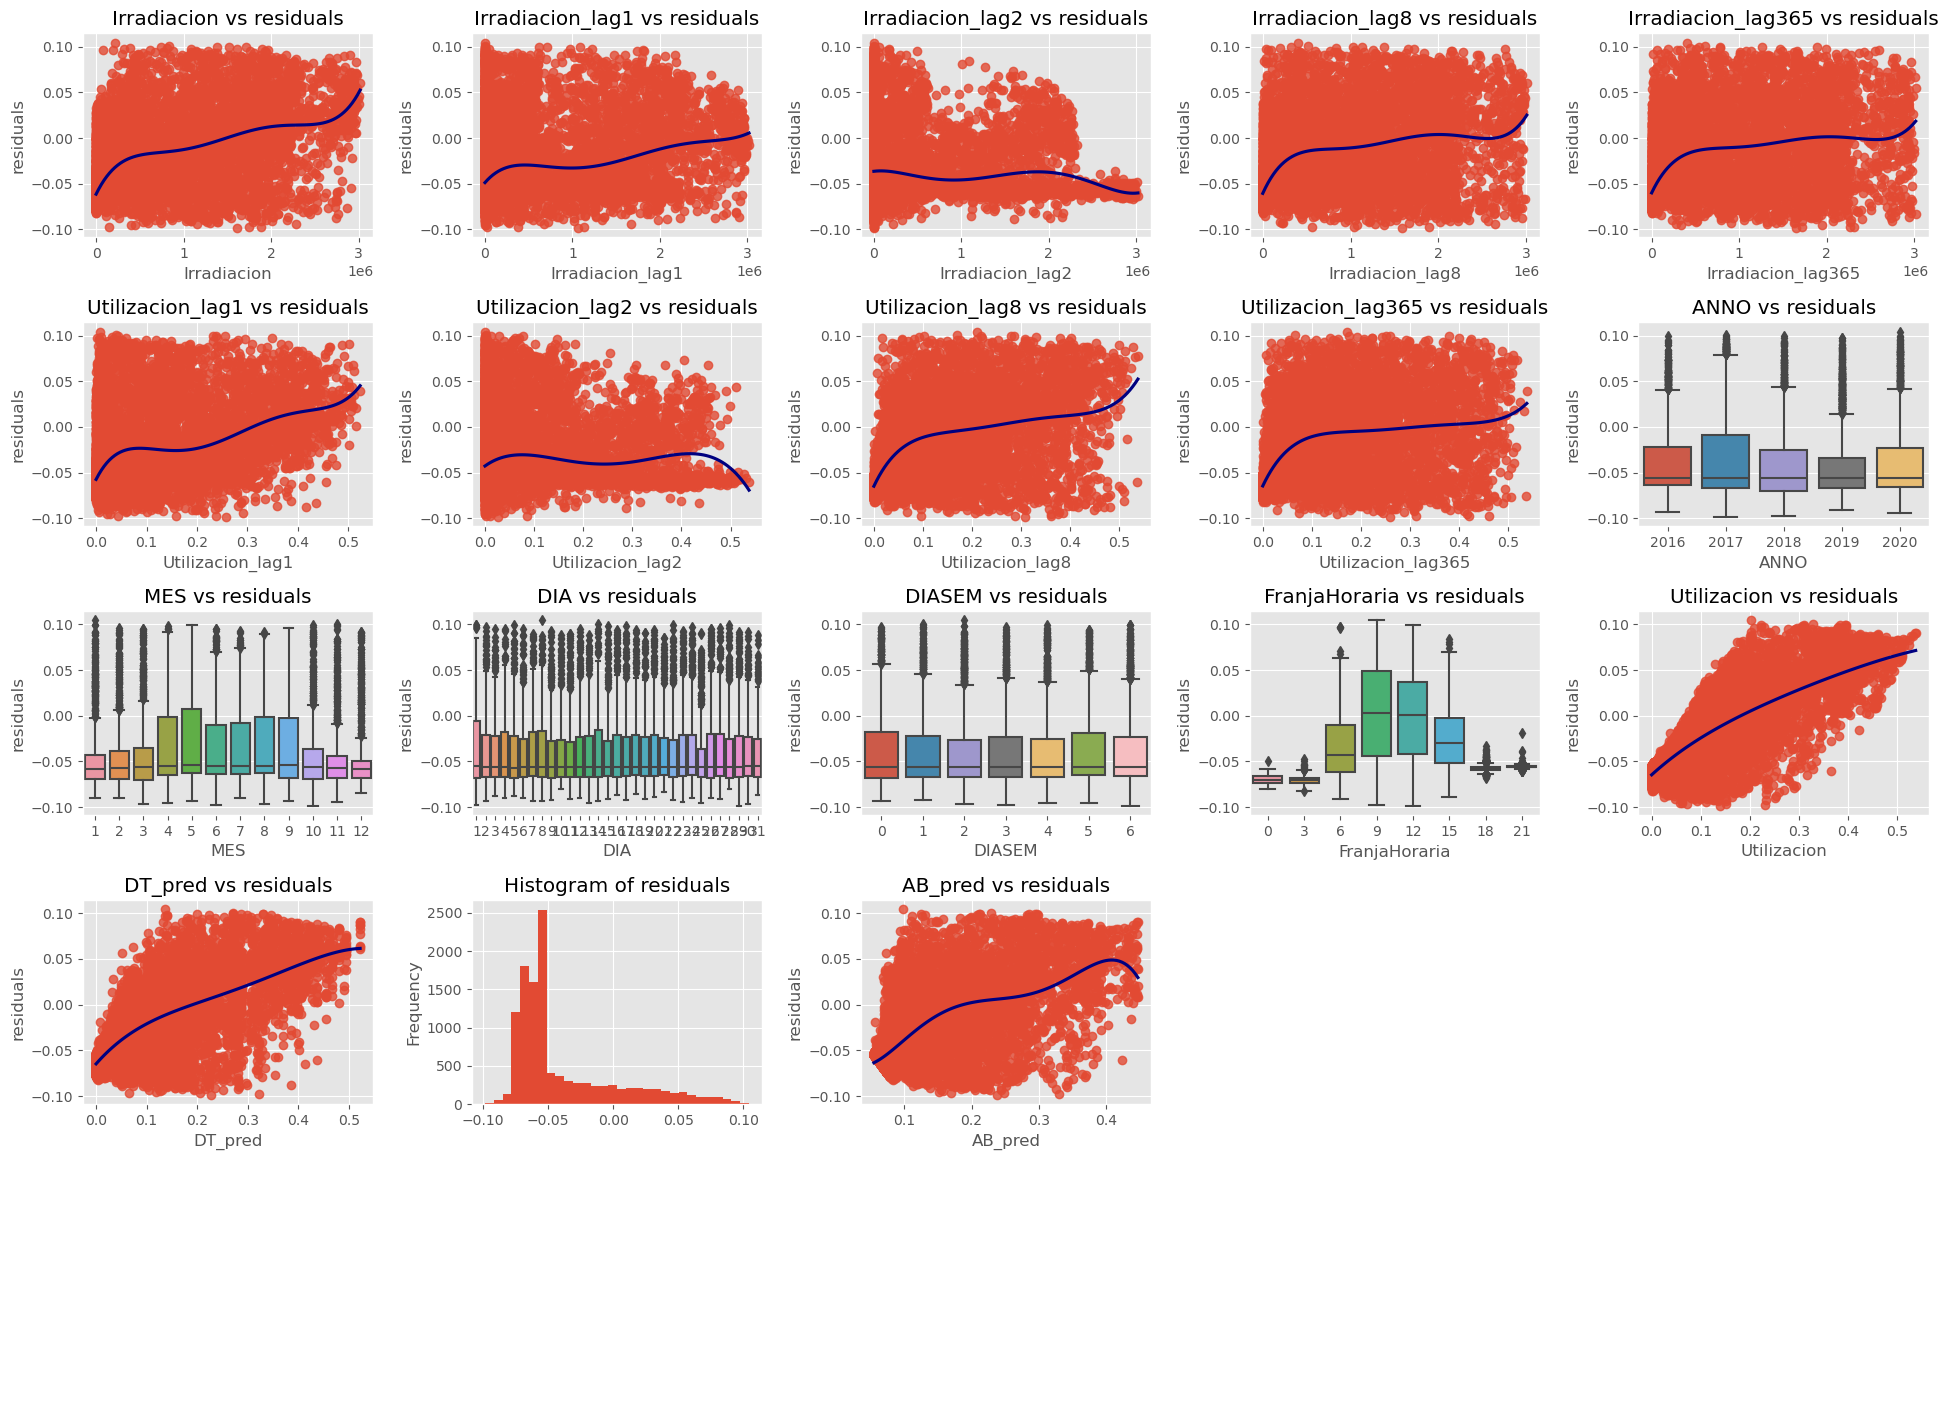

In [25]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'AB_pred', 'Utilizacion', figsize=[20,15])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Normalized Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Normalized Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()

##### c) Gradient boosting

In [65]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Usar np.linspace para generar un rango de valores flotantes para 'min_impurity_decrease'
min_impurity_decrease_values = np.linspace(0.0, 0.01 * np.var(y_train), num=3)

# Definimos los rangos de parámetros para la búsqueda en cuadrícula usando range para valores enteros
param_grid = {
    'GBR__n_estimators': range(1000, 5001, 2000),  # Valores de 1000 a 5000 con paso de 2000
    'GBR__learning_rate': [0.01, 0.1, 1.0],  # Lista explícita para valores flotantes
    'GBR__max_depth': range(1, 6, 2),  # Profundidades de 1 a 5 con paso de 2
    'GBR__min_impurity_decrease': min_impurity_decrease_values  # Valores flotantes generados anteriormente
}

# Prepare de data
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM),
        ('cat', categorical_transformer, INPUTS_CAT)
        ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('GBR', 
                        GradientBoostingRegressor(max_features=1.0, 
                                   loss='squared_error', 
                                   min_samples_split=2,
                                   min_samples_leaf=1, 
                                   random_state=0))])


# Crear el objeto GridSearchCV
nFolds = 10
GB_reg_fit = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=nFolds, 
                           verbose=1, 
                           n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
GB_reg_fit.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados por GridSearchCV
print("Best parameters found: ", GB_reg_fit.best_params_)


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters found:  {'GBR__learning_rate': 0.01, 'GBR__max_depth': 5, 'GBR__min_impurity_decrease': 0.00013406326245115968, 'GBR__n_estimators': 3000}


In [66]:
# Predict
y_train_est = GB_reg_fit.predict(X_train)
y_test_est = GB_reg_fit.predict(X_test)
# Obtain a report of the model based on predictions
dfTR_eval['GB_pred'] = y_train_est
dfTS_eval['GB_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['GB_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['GB_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['GB_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['GB_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['GB_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['GB_pred']))

Training MAE: 0.007827201321407807
Test MAE: 0.013476828811673376
Training RMSE: 0.013766195215974069
Test RMSE: 0.025358769468423085
Training R2: 0.9858642757710487
Test R2: 0.9505559294704062


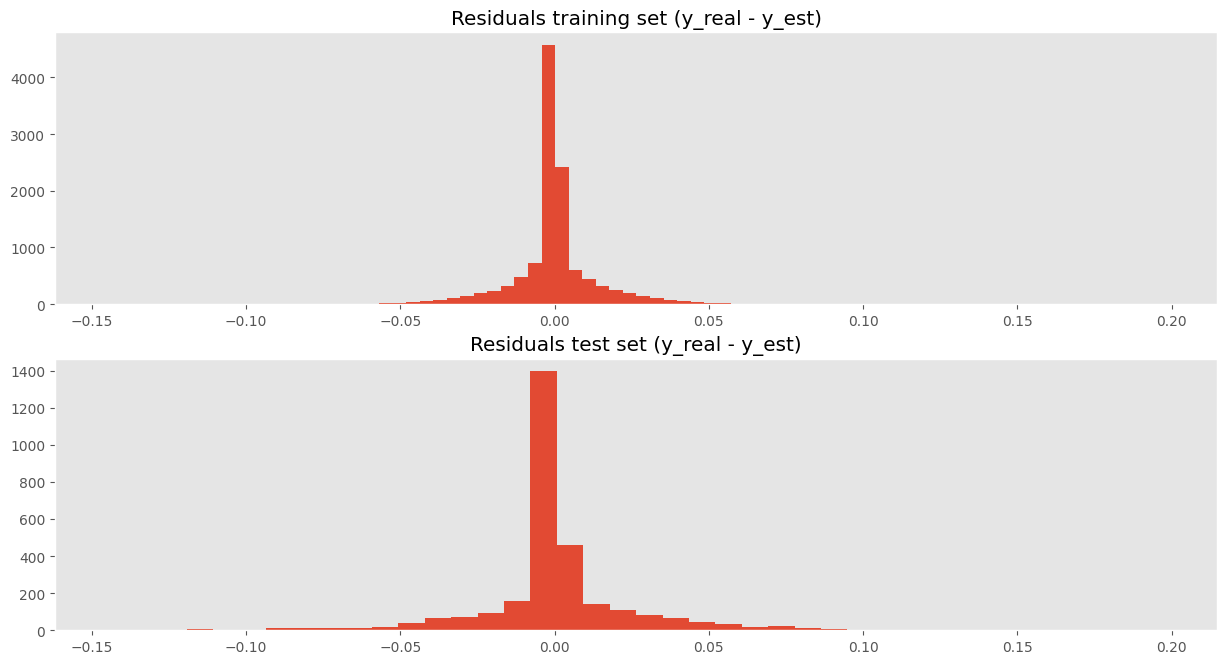

In [67]:
# Histogram of residuals

plt.figure(figsize=(15, 12))

ax=plt.subplot(3,1,2)
plt.hist(y_train - y_train_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(3,1,3, sharex = ax)
plt.hist(y_test - y_test_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals test set (y_real - y_est)')
plt.show()

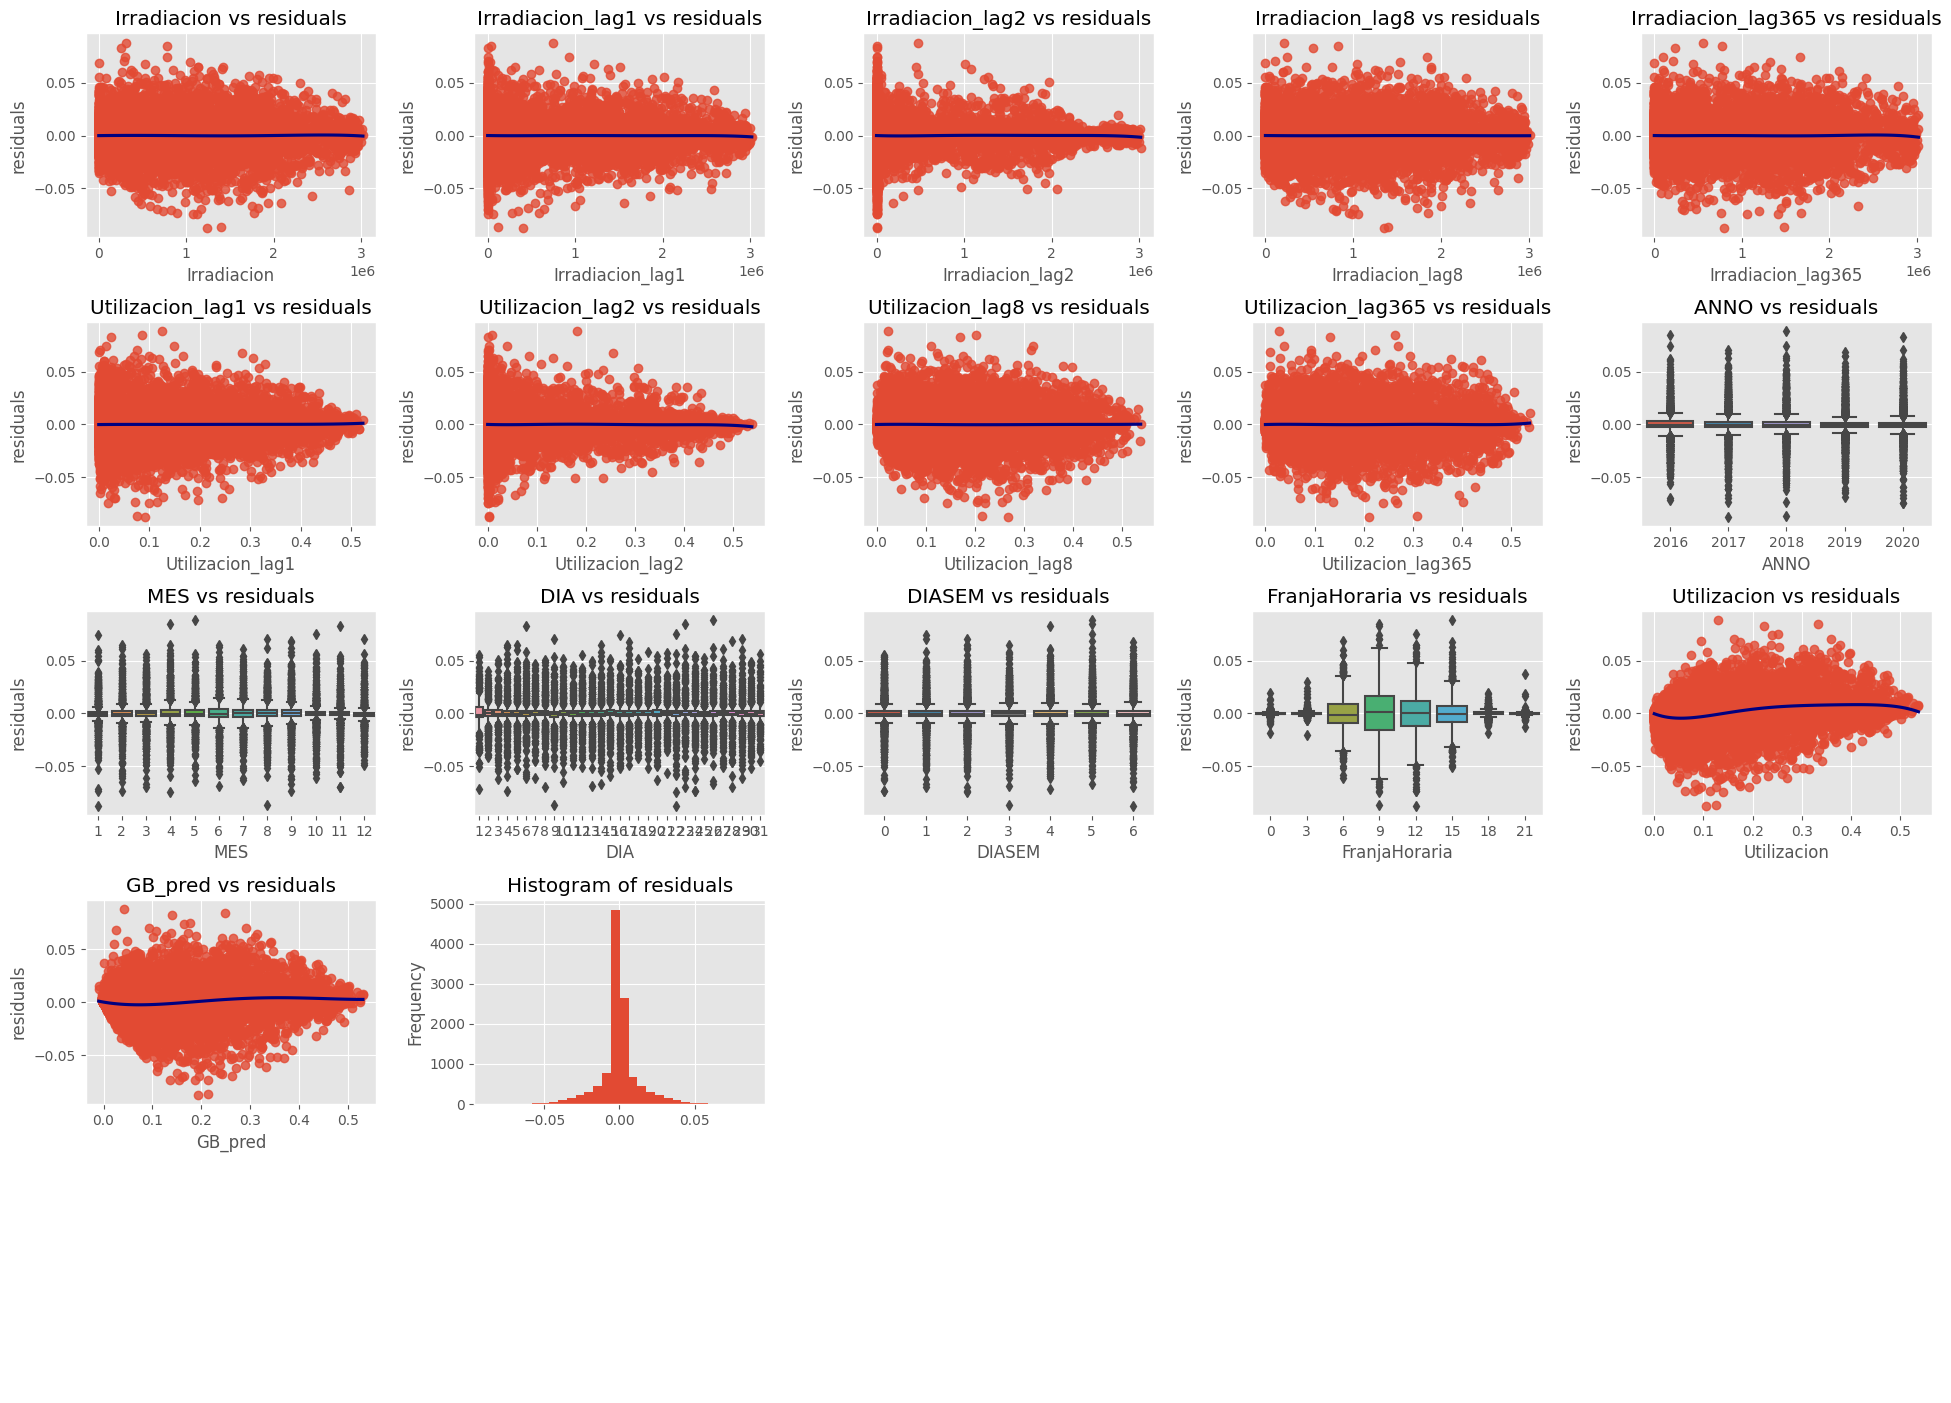

In [68]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'GB_pred', 'Utilizacion', figsize=[20,15])

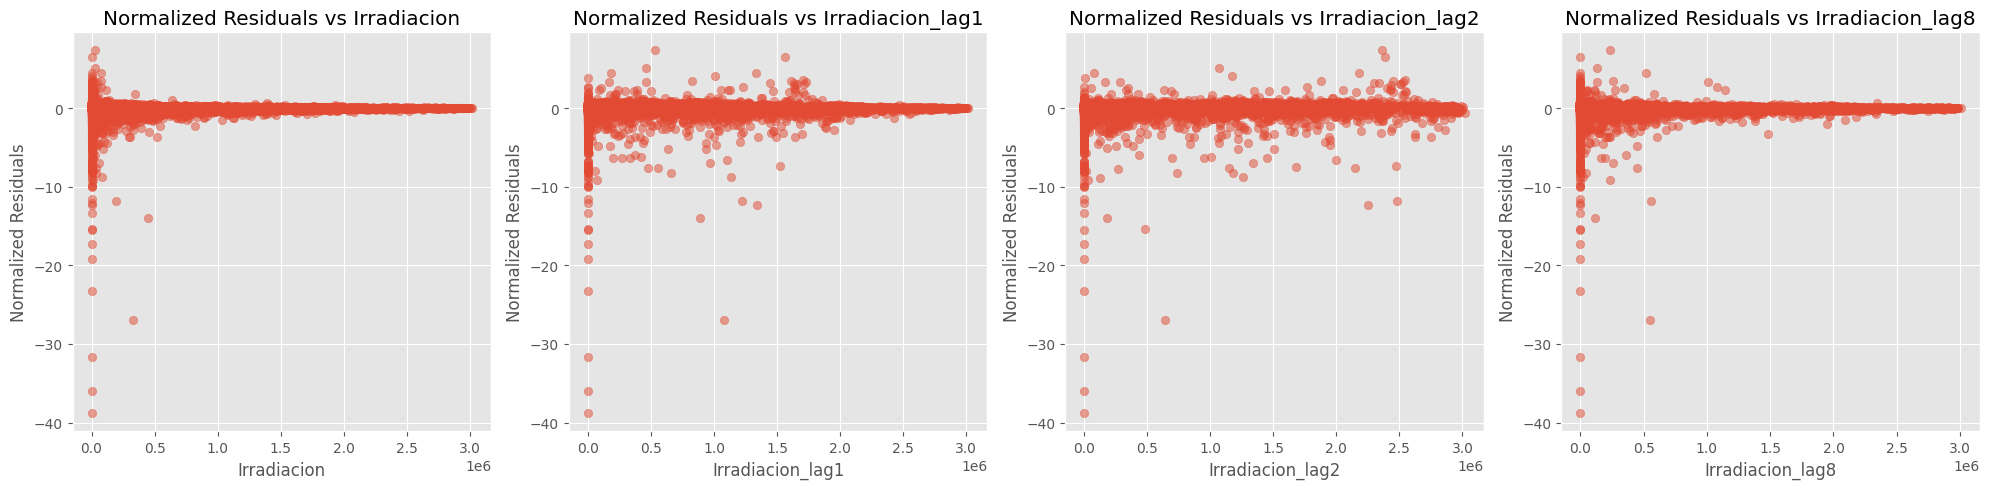

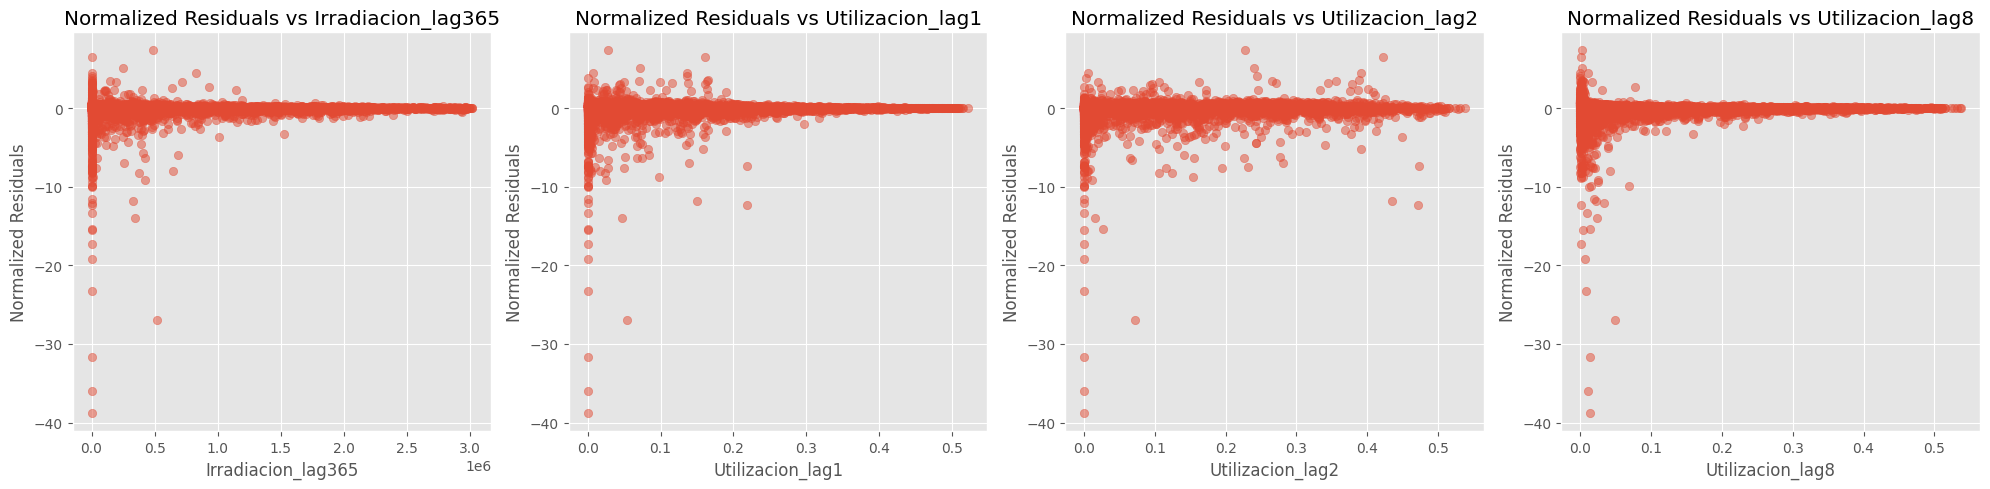

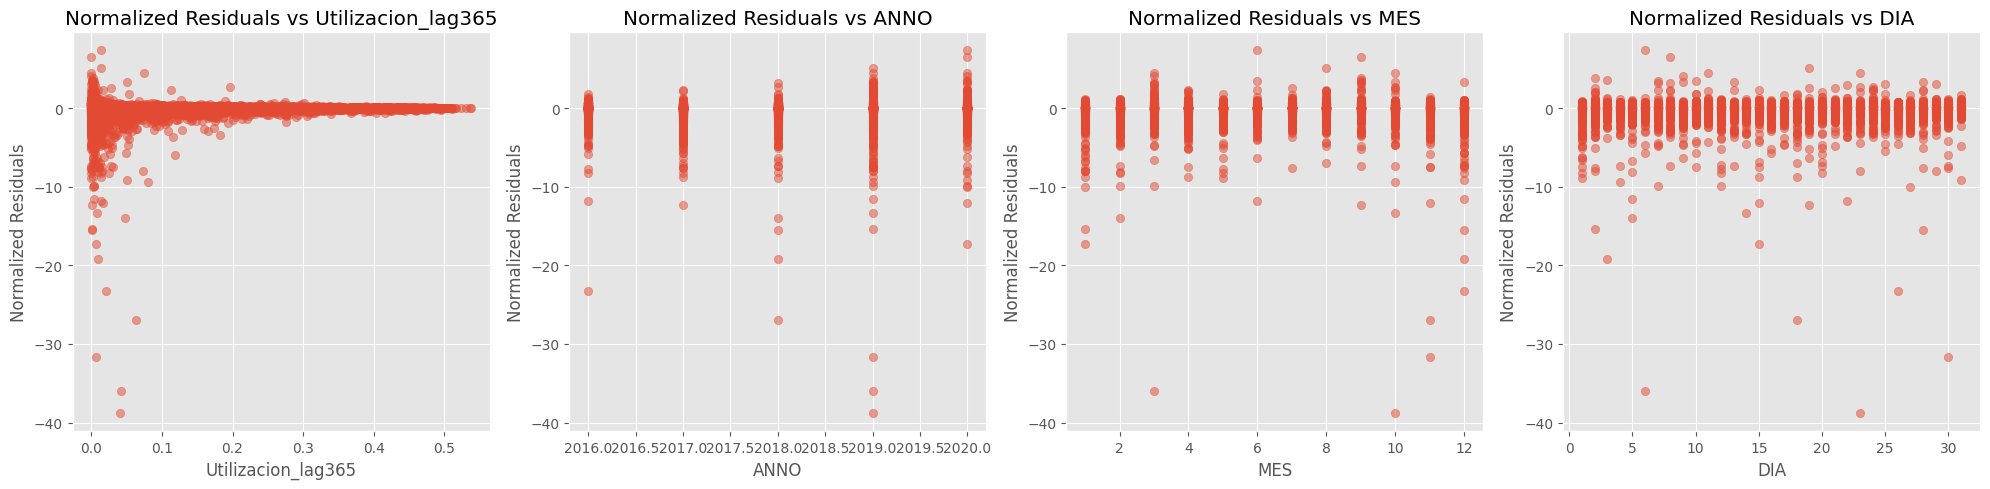

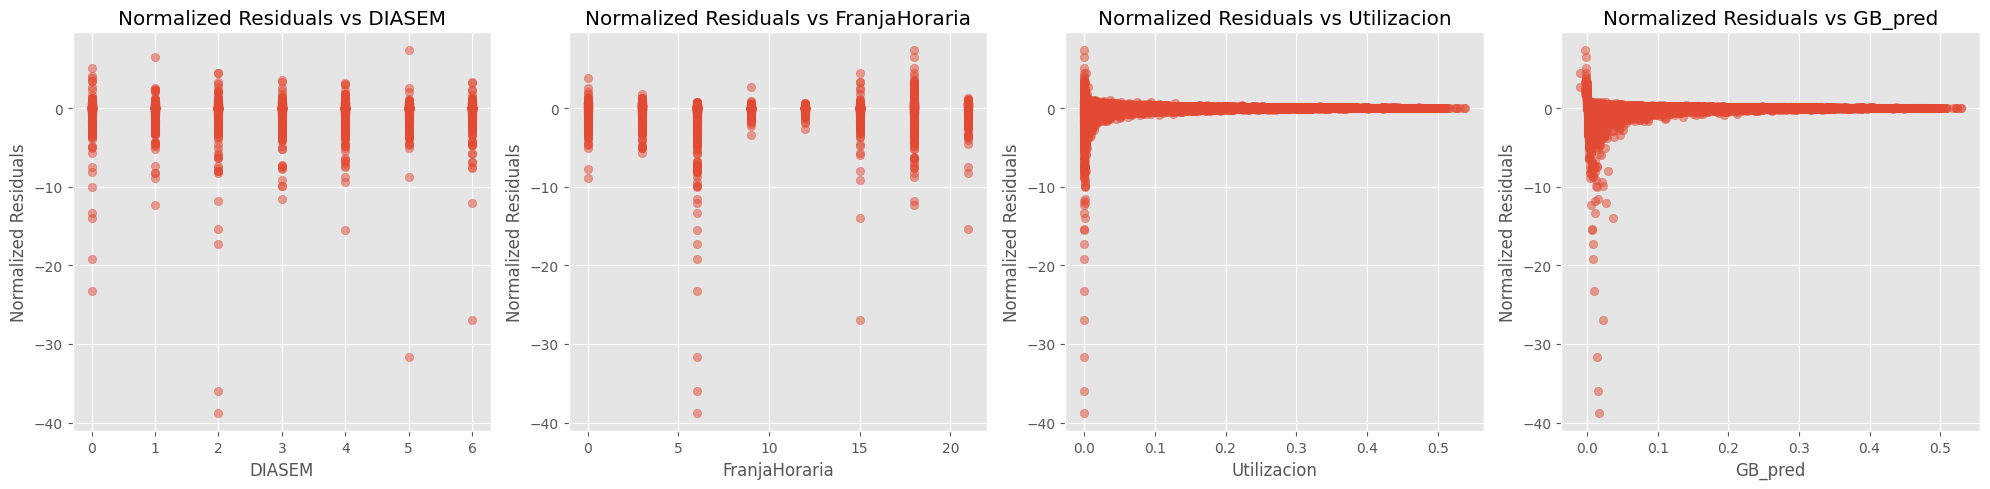

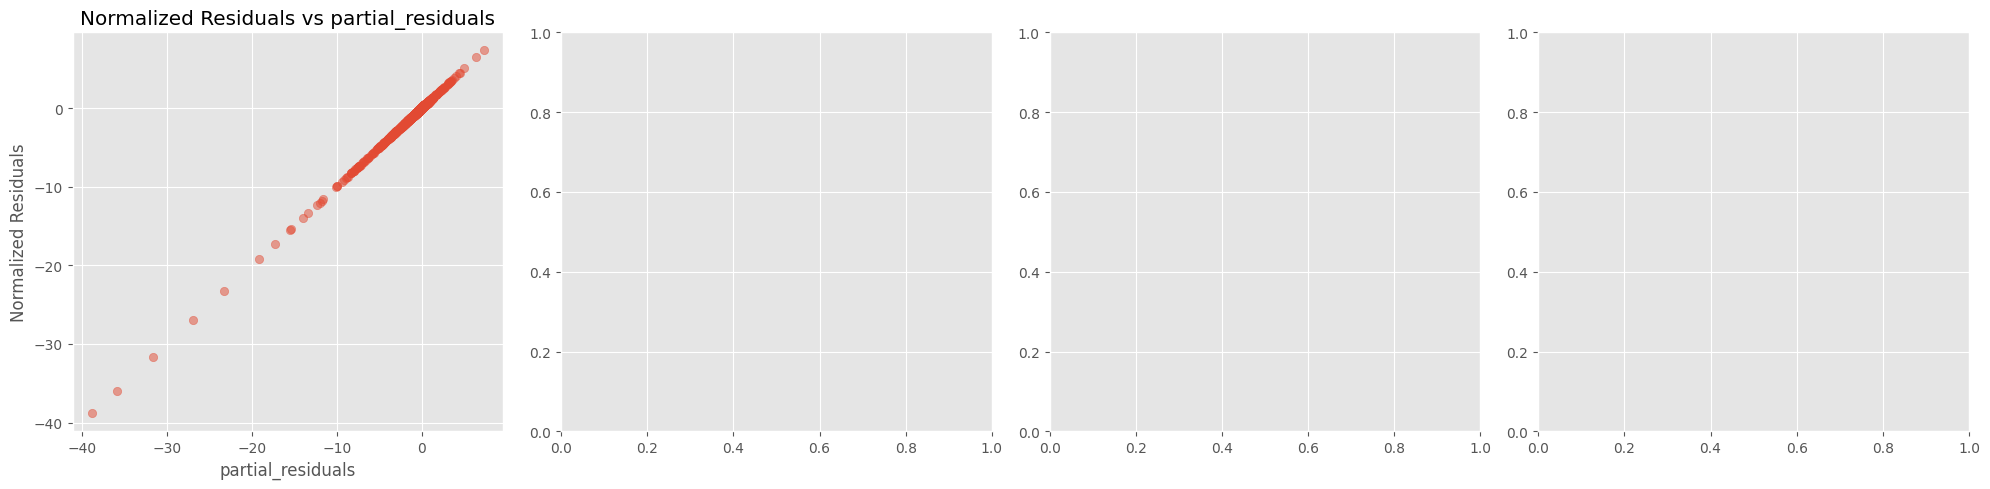

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Normalized Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Normalized Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()